In [1]:
import os, sys
cwd = os.getcwd()

api_path_sampling = os.path.join(cwd, '..', 'tools', 'sampling_utils')
api_path_gan_metrics = os.path.join(cwd, '..', 'tools', 'gan_metrics')
api_path_cifar = os.path.join(cwd, '..', 'tools', 'cifar10_utils')
api_path_celeba = os.path.join(cwd, '..', 'tools', 'celeba_utils')

sys.path.extend([api_path_sampling, api_path_gan_metrics, api_path_cifar, api_path_celeba])

import os
import re
from typing import List, Optional

import click
import numpy as np
import PIL.Image
import torch
import random
from functools import partial
from tqdm import tqdm

from matplotlib import pyplot as plt

from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          aggregate_sampling_output,
                          load_data_from_batches,
                          mala_sampling,
                          gan_energy)
from general_utils import to_var, to_np, DotDict

from cifar10_utils import plot_scores_cifar10_dynamics

from celeba_utils import calculate_celeba_statistics, save_images_for_fid_fix_latent

import time
from metrics import inception_score

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from fid_score import calculate_fid_given_paths
from distributions import IndependentNormal

In [2]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
device = torch.device('cuda:1')
D = model.getOriginalD()
G = model.getOriginalG()
G = G.eval().requires_grad_(False).to(device)
D = D.eval().requires_grad_(False).to(device)

In [20]:
num_images = 32
noise, _ = model.buildNoiseData(num_images)
noise = noise.to(device)
generated_images = G(noise)

In [21]:
D(generated_images)

tensor([[ 1.6316],
        [ 0.6271],
        [-2.1793],
        [ 0.5504],
        [ 1.5895],
        [ 1.0649],
        [ 2.1929],
        [ 2.4509],
        [ 2.5986],
        [ 0.8828],
        [ 1.2782],
        [ 2.7130],
        [-0.4843],
        [ 0.1036],
        [ 1.2691],
        [ 0.6137],
        [ 1.1274],
        [ 0.8783],
        [ 0.1456],
        [ 0.8712],
        [ 0.6914],
        [-0.6868],
        [ 0.9187],
        [ 0.5306],
        [-2.4387],
        [ 0.2865],
        [ 0.1146],
        [ 0.6380],
        [-0.2999],
        [ 1.7722],
        [ 0.1590],
        [-0.0941]], device='cuda:1')

In [22]:
generated_images.min()

tensor(-1.5542, device='cuda:1')

In [23]:
generated_images.max()

tensor(1.7528, device='cuda:1')

In [24]:
generated_images.shape

torch.Size([32, 3, 128, 128])

In [25]:
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size)])
generated_images_transform = (transform(generated_images).clamp(min=-1, max=1) + 1.)/2



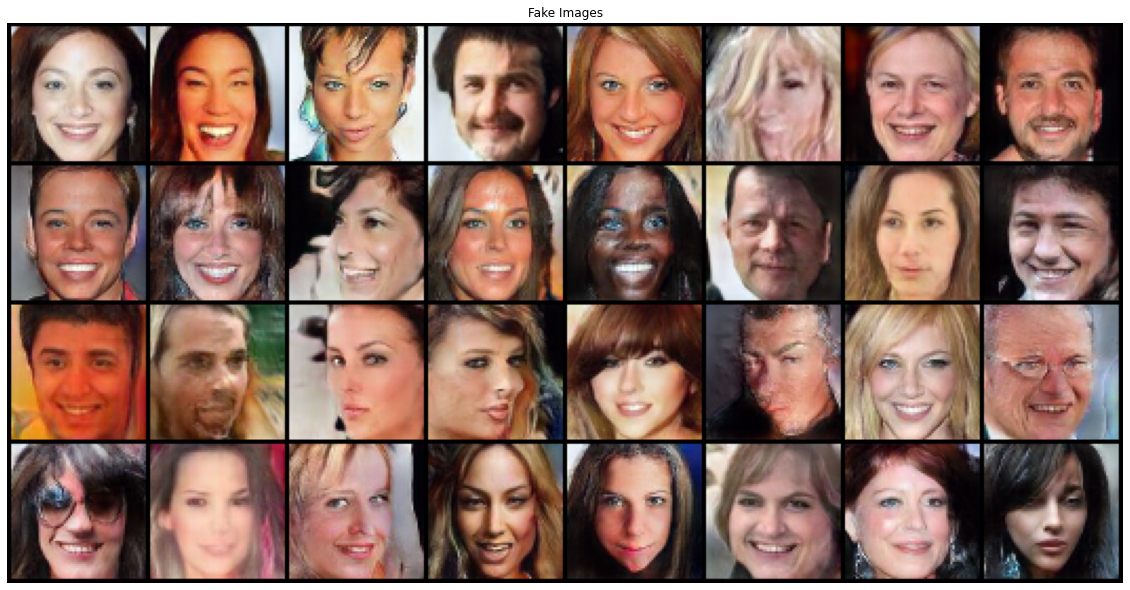

In [26]:
grid = torchvision.utils.make_grid(generated_images_transform, scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [23]:
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
workers = 2
batch_size = 45
real_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

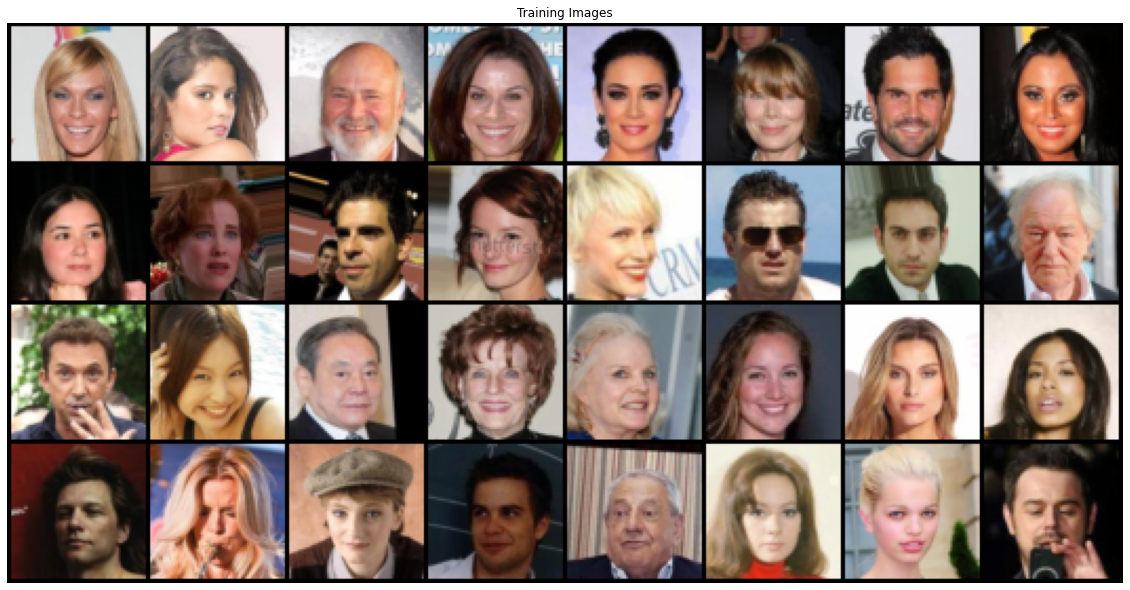

In [20]:
real_batch = next(iter(real_dataloader))
real_images = real_batch[0].to(device)[:64]
plt.figure(figsize=(20, 20))
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_images, 
                                         padding=2, normalize=True).cpu(),
                        (1,2,0))
          )
plt.axis("off")
plt.show()

In [78]:
real_images.min()

tensor(-1., device='cuda:1')

In [79]:
real_images.max()

tensor(1., device='cuda:1')

In [7]:
real_images.shape

torch.Size([32, 3, 64, 64])

In [6]:
nsamples = 50000
noise, _ = model.buildNoiseData(nsamples)
latent_dataset = LatentFixDatasetCeleba(noise, G, 
                                        device, nsamples)

In [6]:
start = time.time()
batch_size = 64
(inception_score_mean, 
 inception_score_std) = inception_score(latent_dataset, 
                                        device, 
                                        batch_size, True)
consumed_time = time.time() - start



Start to make predictions
Start to compute KL divergence


In [7]:
consumed_time


1632.5388934612274

In [9]:
inception_score_mean

3.0295146421481105

In [10]:
inception_score_std

0.01321523786761441

In [53]:
path_to_save_np = "/home/daniil/gans-mcmc/saved_numpy_arrays"
name_fake_train = os.path.join(path_to_save_np, "train_fake_celeba.npy")
name_real_train = os.path.join(path_to_save_np, "train_real_celeba.npy")
image_size = 64
transform = transforms.Compose([transforms.Resize(image_size)])
random_seed = 42

noise = torch.randn(50000, 512)

start = time.time()
save_images_for_fid_fix_latent(G,
                               real_dataloader,
                               name_fake_train,
                               name_real_train,
                               noise,
                               device, 
                               transform,
                               random_seed)   
consumed_time = time.time() - start

1111it [03:58,  4.66it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


In [27]:
chech = np.load(name_fake_train)

In [28]:
chech.shape

(10035, 3, 64, 64)

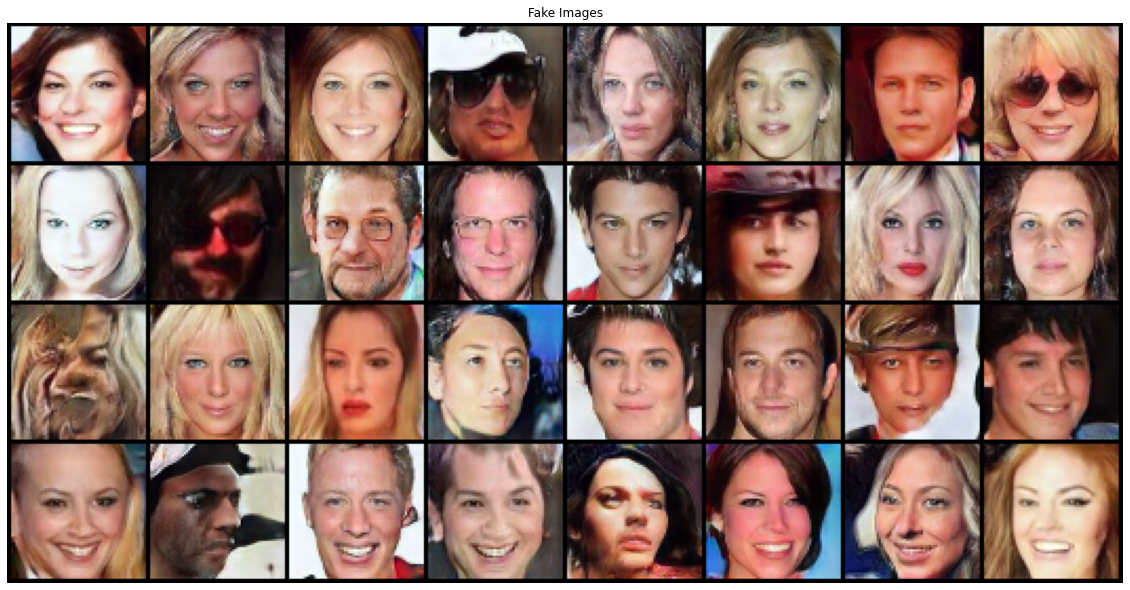

In [29]:
grid = torchvision.utils.make_grid(torch.FloatTensor(chech[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Fake Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [30]:
chech.min()

0.0

In [31]:
chech.max()

1.0

In [21]:
check = np.load(name_real_train)

In [22]:
check.min()

0.0

In [23]:
check.max()

1.0

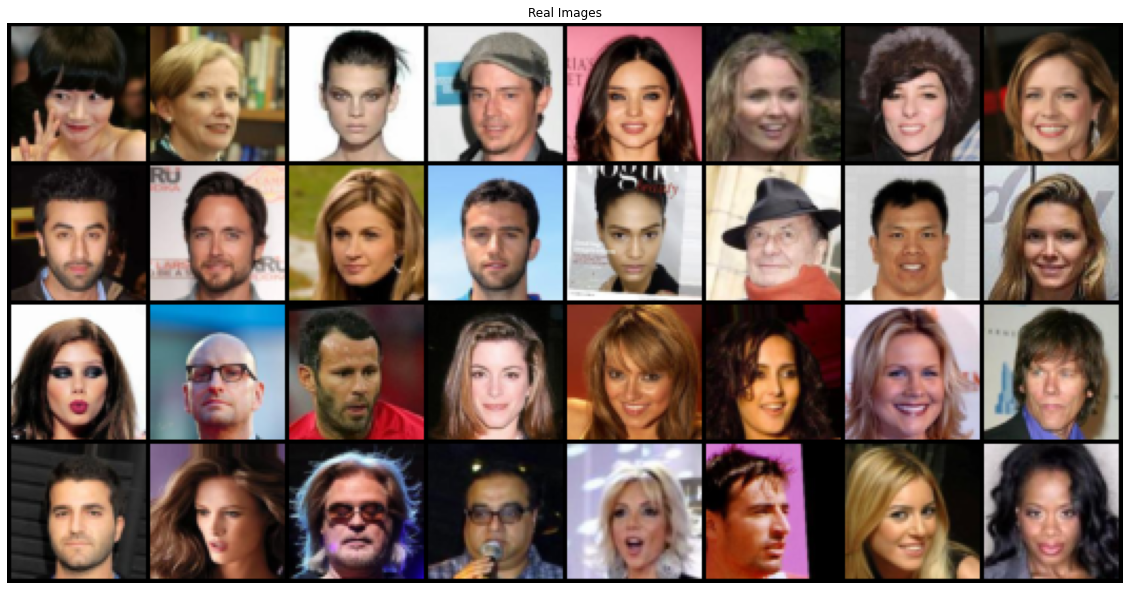

In [20]:
grid = torchvision.utils.make_grid(torch.FloatTensor(chech[:32]), scale_each=True, normalize=True)
plt.figure(figsize=(20, 20))
plt.title("Real Images")
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

In [54]:
batch_size_resnet = 45
dim_resnet = 2048
model_type = 'inception'
cuda = True

paths_to_train_method = [name_real_train, name_fake_train]

results_fid_train = calculate_fid_given_paths(paths_to_train_method, 
                                           batch_size_resnet, 
                                           cuda, 
                                           dim_resnet, 
                                           model_type=model_type)

  0%|          | 2/1111 [00:00<01:34, 11.79it/s]

  0%|          | 2/1111 [00:00<01:27, 12.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/train_fake_celeba.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.38s/it, mean=36.4]


In [33]:
results_fid_train_first = results_fid_train[0]

mean_fid_train = results_fid_train_first[1]
std_fid_train = results_fid_train_first[2]
print(mean_fid_train)
print(std_fid_train)

39.62905482501303
0.28888942696649983


In [36]:
batch_size_resnet = 50
dim_resnet = 2048
model_type = 'inception'
cuda = True

paths_to_train_method = [name_real_train, name_fake_train]

results_fid_train = calculate_fid_given_paths(paths_to_train_method, 
                                           batch_size_resnet, 
                                           cuda, 
                                           dim_resnet, 
                                           model_type=model_type)

  0%|          | 2/1000 [00:00<01:26, 11.50it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/train_fake_celeba.npy


FID: 100%|██████████| 10/10 [01:21<00:00,  8.20s/it, mean=19]


In [37]:
results_fid_train_first = results_fid_train[0]

mean_fid_train = results_fid_train_first[1]
std_fid_train = results_fid_train_first[2]
print(mean_fid_train)
print(std_fid_train)

19.04734363852969
0.08064274583875268


# ULA

In [20]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)


Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [3]:
noise, _ = model.buildNoiseData(1)
z_dim = noise.shape[1]

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [4]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = langevin_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 1/223 [01:23<5:08:30, 83.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 45, 512)


  1%|          | 2/223 [02:49<5:09:53, 84.13s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_45.npy was saved, file shape = (21, 45, 512)


  1%|▏         | 3/223 [04:15<5:10:39, 84.72s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_90.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 4/223 [05:41<5:10:39, 85.11s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_135.npy was saved, file shape = (21, 45, 512)


  2%|▏         | 5/223 [07:07<5:10:13, 85.38s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_180.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 6/223 [08:33<5:09:29, 85.58s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_225.npy was saved, file shape = (21, 45, 512)


  3%|▎         | 7/223 [09:59<5:08:38, 85.74s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_270.npy was saved, file shape = (21, 45, 512)


  4%|▎         | 8/223 [11:25<5:07:38, 85.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_315.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 9/223 [12:51<5:06:23, 85.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_360.npy was saved, file shape = (21, 45, 512)


  4%|▍         | 10/223 [14:17<5:05:07, 85.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_405.npy was saved, file shape = (21, 45, 512)


  5%|▍         | 11/223 [15:43<5:03:48, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_450.npy was saved, file shape = (21, 45, 512)


  5%|▌         | 12/223 [17:09<5:02:27, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_495.npy was saved, file shape = (21, 45, 512)


  6%|▌         | 13/223 [18:35<5:01:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_540.npy was saved, file shape = (21, 45, 512)


  6%|▋         | 14/223 [20:01<4:59:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_585.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 15/223 [21:28<4:58:16, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_630.npy was saved, file shape = (21, 45, 512)


  7%|▋         | 16/223 [22:54<4:56:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_675.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 17/223 [24:20<4:55:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_720.npy was saved, file shape = (21, 45, 512)


  8%|▊         | 18/223 [25:46<4:54:00, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_765.npy was saved, file shape = (21, 45, 512)


  9%|▊         | 19/223 [27:12<4:52:33, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_810.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 20/223 [28:38<4:51:07, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_855.npy was saved, file shape = (21, 45, 512)


  9%|▉         | 21/223 [30:04<4:49:42, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_900.npy was saved, file shape = (21, 45, 512)


 10%|▉         | 22/223 [31:30<4:48:17, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_945.npy was saved, file shape = (21, 45, 512)


 10%|█         | 23/223 [32:56<4:46:51, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_990.npy was saved, file shape = (21, 45, 512)


 11%|█         | 24/223 [34:22<4:45:24, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1035.npy was saved, file shape = (21, 45, 512)


 11%|█         | 25/223 [35:48<4:43:56, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1080.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 26/223 [37:14<4:42:28, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1125.npy was saved, file shape = (21, 45, 512)


 12%|█▏        | 27/223 [38:40<4:41:02, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1170.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 28/223 [40:06<4:39:34, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1215.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 29/223 [41:32<4:38:08, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1260.npy was saved, file shape = (21, 45, 512)


 13%|█▎        | 30/223 [42:58<4:36:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1305.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 31/223 [44:24<4:35:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1350.npy was saved, file shape = (21, 45, 512)


 14%|█▍        | 32/223 [45:50<4:33:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1395.npy was saved, file shape = (21, 45, 512)


 15%|█▍        | 33/223 [47:16<4:32:24, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 45, 512)


 15%|█▌        | 34/223 [48:42<4:31:00, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1485.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 35/223 [50:08<4:29:33, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1530.npy was saved, file shape = (21, 45, 512)


 16%|█▌        | 36/223 [51:34<4:28:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1575.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 37/223 [53:00<4:26:42, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1620.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 38/223 [54:26<4:25:18, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1665.npy was saved, file shape = (21, 45, 512)


 17%|█▋        | 39/223 [55:53<4:23:53, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1710.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 40/223 [57:19<4:22:29, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1755.npy was saved, file shape = (21, 45, 512)


 18%|█▊        | 41/223 [58:45<4:21:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1800.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 42/223 [1:00:11<4:19:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1845.npy was saved, file shape = (21, 45, 512)


 19%|█▉        | 43/223 [1:01:37<4:18:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1890.npy was saved, file shape = (21, 45, 512)


 20%|█▉        | 44/223 [1:03:03<4:16:43, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1935.npy was saved, file shape = (21, 45, 512)


 20%|██        | 45/223 [1:04:29<4:15:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1980.npy was saved, file shape = (21, 45, 512)


 21%|██        | 46/223 [1:05:55<4:13:48, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2025.npy was saved, file shape = (21, 45, 512)


 21%|██        | 47/223 [1:07:21<4:12:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2070.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 48/223 [1:08:47<4:10:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2115.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 49/223 [1:10:13<4:09:29, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2160.npy was saved, file shape = (21, 45, 512)


 22%|██▏       | 50/223 [1:11:39<4:08:04, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2205.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 51/223 [1:13:05<4:06:39, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2250.npy was saved, file shape = (21, 45, 512)


 23%|██▎       | 52/223 [1:14:31<4:05:14, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2295.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 53/223 [1:15:57<4:03:49, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2340.npy was saved, file shape = (21, 45, 512)


 24%|██▍       | 54/223 [1:17:23<4:02:22, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2385.npy was saved, file shape = (21, 45, 512)


 25%|██▍       | 55/223 [1:18:49<4:00:54, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2430.npy was saved, file shape = (21, 45, 512)


 25%|██▌       | 56/223 [1:20:15<3:59:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2475.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 57/223 [1:21:41<3:58:01, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2520.npy was saved, file shape = (21, 45, 512)


 26%|██▌       | 58/223 [1:23:07<3:56:39, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2565.npy was saved, file shape = (21, 45, 512)


 26%|██▋       | 59/223 [1:24:33<3:55:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2610.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 60/223 [1:26:00<3:53:48, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2655.npy was saved, file shape = (21, 45, 512)


 27%|██▋       | 61/223 [1:27:26<3:52:22, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2700.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 62/223 [1:28:52<3:50:56, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2745.npy was saved, file shape = (21, 45, 512)


 28%|██▊       | 63/223 [1:30:18<3:49:30, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2790.npy was saved, file shape = (21, 45, 512)


 29%|██▊       | 64/223 [1:31:44<3:48:03, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2835.npy was saved, file shape = (21, 45, 512)


 29%|██▉       | 65/223 [1:33:10<3:46:37, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 45, 512)


 30%|██▉       | 66/223 [1:34:36<3:45:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2925.npy was saved, file shape = (21, 45, 512)


 30%|███       | 67/223 [1:36:02<3:43:45, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2970.npy was saved, file shape = (21, 45, 512)


 30%|███       | 68/223 [1:37:28<3:42:17, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3015.npy was saved, file shape = (21, 45, 512)


 31%|███       | 69/223 [1:38:54<3:40:51, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3060.npy was saved, file shape = (21, 45, 512)


 31%|███▏      | 70/223 [1:40:20<3:39:26, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3105.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 71/223 [1:41:46<3:38:02, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3150.npy was saved, file shape = (21, 45, 512)


 32%|███▏      | 72/223 [1:43:12<3:36:37, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3195.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 73/223 [1:44:38<3:35:11, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3240.npy was saved, file shape = (21, 45, 512)


 33%|███▎      | 74/223 [1:46:04<3:33:44, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3285.npy was saved, file shape = (21, 45, 512)


 34%|███▎      | 75/223 [1:47:30<3:32:17, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3330.npy was saved, file shape = (21, 45, 512)


 34%|███▍      | 76/223 [1:48:57<3:30:51, 86.07s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3375.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 77/223 [1:50:23<3:29:25, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3420.npy was saved, file shape = (21, 45, 512)


 35%|███▍      | 78/223 [1:51:49<3:27:58, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3465.npy was saved, file shape = (21, 45, 512)


 35%|███▌      | 79/223 [1:53:15<3:26:31, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3510.npy was saved, file shape = (21, 45, 512)


 36%|███▌      | 80/223 [1:54:41<3:25:05, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3555.npy was saved, file shape = (21, 45, 512)


 36%|███▋      | 81/223 [1:56:07<3:23:39, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3600.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 82/223 [1:57:33<3:22:12, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3645.npy was saved, file shape = (21, 45, 512)


 37%|███▋      | 83/223 [1:58:59<3:20:46, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3690.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 84/223 [2:00:25<3:19:21, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3735.npy was saved, file shape = (21, 45, 512)


 38%|███▊      | 85/223 [2:01:51<3:17:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3780.npy was saved, file shape = (21, 45, 512)


 39%|███▊      | 86/223 [2:03:17<3:16:28, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3825.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 87/223 [2:04:43<3:15:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3870.npy was saved, file shape = (21, 45, 512)


 39%|███▉      | 88/223 [2:06:09<3:13:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3915.npy was saved, file shape = (21, 45, 512)


 40%|███▉      | 89/223 [2:07:35<3:12:11, 86.06s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3960.npy was saved, file shape = (21, 45, 512)


 40%|████      | 90/223 [2:09:01<3:10:43, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4005.npy was saved, file shape = (21, 45, 512)


 41%|████      | 91/223 [2:10:27<3:09:16, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4050.npy was saved, file shape = (21, 45, 512)


 41%|████▏     | 92/223 [2:11:53<3:07:49, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4095.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 93/223 [2:13:19<3:06:23, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4140.npy was saved, file shape = (21, 45, 512)


 42%|████▏     | 94/223 [2:14:45<3:04:58, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4185.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 95/223 [2:16:11<3:03:31, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4230.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 96/223 [2:17:37<3:02:05, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4275.npy was saved, file shape = (21, 45, 512)


 43%|████▎     | 97/223 [2:19:03<3:00:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 98/223 [2:20:29<2:59:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4365.npy was saved, file shape = (21, 45, 512)


 44%|████▍     | 99/223 [2:21:55<2:57:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4410.npy was saved, file shape = (21, 45, 512)


 45%|████▍     | 100/223 [2:23:21<2:56:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4455.npy was saved, file shape = (21, 45, 512)


 45%|████▌     | 101/223 [2:24:47<2:54:54, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4500.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 102/223 [2:26:13<2:53:28, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4545.npy was saved, file shape = (21, 45, 512)


 46%|████▌     | 103/223 [2:27:39<2:52:01, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4590.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 104/223 [2:29:05<2:50:34, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4635.npy was saved, file shape = (21, 45, 512)


 47%|████▋     | 105/223 [2:30:31<2:49:07, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4680.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 106/223 [2:31:57<2:47:41, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4725.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 107/223 [2:33:23<2:46:15, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4770.npy was saved, file shape = (21, 45, 512)


 48%|████▊     | 108/223 [2:34:49<2:44:49, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4815.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 109/223 [2:36:15<2:43:23, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4860.npy was saved, file shape = (21, 45, 512)


 49%|████▉     | 110/223 [2:37:41<2:41:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4905.npy was saved, file shape = (21, 45, 512)


 50%|████▉     | 111/223 [2:39:07<2:40:33, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4950.npy was saved, file shape = (21, 45, 512)


 50%|█████     | 112/223 [2:40:33<2:39:07, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4995.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 113/223 [2:42:00<2:37:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5040.npy was saved, file shape = (21, 45, 512)


 51%|█████     | 114/223 [2:43:26<2:36:16, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5085.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 115/223 [2:44:52<2:34:50, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5130.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 116/223 [2:46:18<2:33:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5175.npy was saved, file shape = (21, 45, 512)


 52%|█████▏    | 117/223 [2:47:44<2:31:58, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5220.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 118/223 [2:49:10<2:30:32, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5265.npy was saved, file shape = (21, 45, 512)


 53%|█████▎    | 119/223 [2:50:36<2:29:07, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5310.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 120/223 [2:52:02<2:27:40, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5355.npy was saved, file shape = (21, 45, 512)


 54%|█████▍    | 121/223 [2:53:28<2:26:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5400.npy was saved, file shape = (21, 45, 512)


 55%|█████▍    | 122/223 [2:54:54<2:24:48, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5445.npy was saved, file shape = (21, 45, 512)


 55%|█████▌    | 123/223 [2:56:20<2:23:21, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5490.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 124/223 [2:57:46<2:21:55, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5535.npy was saved, file shape = (21, 45, 512)


 56%|█████▌    | 125/223 [2:59:12<2:20:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5580.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 126/223 [3:00:38<2:19:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5625.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 127/223 [3:02:04<2:17:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5670.npy was saved, file shape = (21, 45, 512)


 57%|█████▋    | 128/223 [3:03:30<2:16:11, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5715.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 129/223 [3:04:56<2:14:46, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 45, 512)


 58%|█████▊    | 130/223 [3:06:22<2:13:21, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5805.npy was saved, file shape = (21, 45, 512)


 59%|█████▊    | 131/223 [3:07:48<2:11:55, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5850.npy was saved, file shape = (21, 45, 512)


 59%|█████▉    | 132/223 [3:09:14<2:10:30, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5895.npy was saved, file shape = (21, 45, 512)


 60%|█████▉    | 133/223 [3:10:40<2:09:03, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5940.npy was saved, file shape = (21, 45, 512)


 60%|██████    | 134/223 [3:12:06<2:07:36, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5985.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 135/223 [3:13:32<2:06:10, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6030.npy was saved, file shape = (21, 45, 512)


 61%|██████    | 136/223 [3:14:58<2:04:44, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6075.npy was saved, file shape = (21, 45, 512)


 61%|██████▏   | 137/223 [3:16:24<2:03:17, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6120.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 138/223 [3:17:50<2:01:52, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6165.npy was saved, file shape = (21, 45, 512)


 62%|██████▏   | 139/223 [3:19:16<2:00:24, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6210.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 140/223 [3:20:42<1:58:58, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6255.npy was saved, file shape = (21, 45, 512)


 63%|██████▎   | 141/223 [3:22:08<1:57:32, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6300.npy was saved, file shape = (21, 45, 512)


 64%|██████▎   | 142/223 [3:23:34<1:56:07, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6345.npy was saved, file shape = (21, 45, 512)


 64%|██████▍   | 143/223 [3:25:00<1:54:41, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6390.npy was saved, file shape = (21, 45, 512)


 65%|██████▍   | 144/223 [3:26:26<1:53:15, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6435.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 145/223 [3:27:52<1:51:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6480.npy was saved, file shape = (21, 45, 512)


 65%|██████▌   | 146/223 [3:29:18<1:50:23, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6525.npy was saved, file shape = (21, 45, 512)


 66%|██████▌   | 147/223 [3:30:44<1:48:57, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6570.npy was saved, file shape = (21, 45, 512)


 66%|██████▋   | 148/223 [3:32:10<1:47:31, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6615.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 149/223 [3:33:36<1:46:05, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6660.npy was saved, file shape = (21, 45, 512)


 67%|██████▋   | 150/223 [3:35:02<1:44:39, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6705.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 151/223 [3:36:28<1:43:13, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6750.npy was saved, file shape = (21, 45, 512)


 68%|██████▊   | 152/223 [3:37:54<1:41:47, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6795.npy was saved, file shape = (21, 45, 512)


 69%|██████▊   | 153/223 [3:39:20<1:40:22, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6840.npy was saved, file shape = (21, 45, 512)


 69%|██████▉   | 154/223 [3:40:46<1:38:55, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6885.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 155/223 [3:42:12<1:37:29, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6930.npy was saved, file shape = (21, 45, 512)


 70%|██████▉   | 156/223 [3:43:38<1:36:03, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6975.npy was saved, file shape = (21, 45, 512)


 70%|███████   | 157/223 [3:45:05<1:34:37, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7020.npy was saved, file shape = (21, 45, 512)


 71%|███████   | 158/223 [3:46:31<1:33:12, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7065.npy was saved, file shape = (21, 45, 512)


 71%|███████▏  | 159/223 [3:47:57<1:31:46, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7110.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 160/223 [3:49:23<1:30:20, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7155.npy was saved, file shape = (21, 45, 512)


 72%|███████▏  | 161/223 [3:50:49<1:28:55, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 162/223 [3:52:15<1:27:29, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7245.npy was saved, file shape = (21, 45, 512)


 73%|███████▎  | 163/223 [3:53:41<1:26:02, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7290.npy was saved, file shape = (21, 45, 512)


 74%|███████▎  | 164/223 [3:55:07<1:24:36, 86.05s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7335.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 165/223 [3:56:33<1:23:10, 86.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7380.npy was saved, file shape = (21, 45, 512)


 74%|███████▍  | 166/223 [3:57:59<1:21:43, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7425.npy was saved, file shape = (21, 45, 512)


 75%|███████▍  | 167/223 [3:59:25<1:20:17, 86.03s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7470.npy was saved, file shape = (21, 45, 512)


 75%|███████▌  | 168/223 [4:00:51<1:18:51, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7515.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 169/223 [4:02:17<1:17:25, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7560.npy was saved, file shape = (21, 45, 512)


 76%|███████▌  | 170/223 [4:03:43<1:15:59, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7605.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 171/223 [4:05:09<1:14:33, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7650.npy was saved, file shape = (21, 45, 512)


 77%|███████▋  | 172/223 [4:06:35<1:13:06, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7695.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 173/223 [4:08:01<1:11:40, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7740.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 174/223 [4:09:27<1:10:14, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7785.npy was saved, file shape = (21, 45, 512)


 78%|███████▊  | 175/223 [4:10:53<1:08:49, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7830.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 176/223 [4:12:19<1:07:22, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7875.npy was saved, file shape = (21, 45, 512)


 79%|███████▉  | 177/223 [4:13:45<1:05:56, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7920.npy was saved, file shape = (21, 45, 512)


 80%|███████▉  | 178/223 [4:15:11<1:04:30, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7965.npy was saved, file shape = (21, 45, 512)


 80%|████████  | 179/223 [4:16:37<1:03:04, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8010.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 180/223 [4:18:03<1:01:38, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8055.npy was saved, file shape = (21, 45, 512)


 81%|████████  | 181/223 [4:19:29<1:00:12, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8100.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 182/223 [4:20:55<58:46, 86.02s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8145.npy was saved, file shape = (21, 45, 512)


 82%|████████▏ | 183/223 [4:22:21<57:20, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8190.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 184/223 [4:23:47<55:54, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8235.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 185/223 [4:25:13<54:27, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8280.npy was saved, file shape = (21, 45, 512)


 83%|████████▎ | 186/223 [4:26:39<53:01, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8325.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 187/223 [4:28:05<51:35, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8370.npy was saved, file shape = (21, 45, 512)


 84%|████████▍ | 188/223 [4:29:31<50:10, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8415.npy was saved, file shape = (21, 45, 512)


 85%|████████▍ | 189/223 [4:30:57<48:43, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8460.npy was saved, file shape = (21, 45, 512)


 85%|████████▌ | 190/223 [4:32:23<47:17, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8505.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 191/223 [4:33:49<45:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8550.npy was saved, file shape = (21, 45, 512)


 86%|████████▌ | 192/223 [4:35:15<44:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8595.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 193/223 [4:36:41<42:59, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 194/223 [4:38:07<41:33, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8685.npy was saved, file shape = (21, 45, 512)


 87%|████████▋ | 195/223 [4:39:33<40:07, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8730.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 196/223 [4:40:59<38:41, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8775.npy was saved, file shape = (21, 45, 512)


 88%|████████▊ | 197/223 [4:42:25<37:15, 85.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8820.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 198/223 [4:43:51<35:49, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8865.npy was saved, file shape = (21, 45, 512)


 89%|████████▉ | 199/223 [4:45:17<34:23, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8910.npy was saved, file shape = (21, 45, 512)


 90%|████████▉ | 200/223 [4:46:43<32:57, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8955.npy was saved, file shape = (21, 45, 512)


 90%|█████████ | 201/223 [4:48:09<31:31, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 202/223 [4:49:35<30:05, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9045.npy was saved, file shape = (21, 45, 512)


 91%|█████████ | 203/223 [4:51:01<28:40, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9090.npy was saved, file shape = (21, 45, 512)


 91%|█████████▏| 204/223 [4:52:27<27:14, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9135.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 205/223 [4:53:53<25:48, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9180.npy was saved, file shape = (21, 45, 512)


 92%|█████████▏| 206/223 [4:55:19<24:22, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9225.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 207/223 [4:56:45<22:55, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9270.npy was saved, file shape = (21, 45, 512)


 93%|█████████▎| 208/223 [4:58:11<21:30, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9315.npy was saved, file shape = (21, 45, 512)


 94%|█████████▎| 209/223 [4:59:37<20:03, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9360.npy was saved, file shape = (21, 45, 512)


 94%|█████████▍| 210/223 [5:01:03<18:37, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9405.npy was saved, file shape = (21, 45, 512)


 95%|█████████▍| 211/223 [5:02:29<17:11, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9450.npy was saved, file shape = (21, 45, 512)


 95%|█████████▌| 212/223 [5:03:55<15:45, 85.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9495.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 213/223 [5:05:21<14:19, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9540.npy was saved, file shape = (21, 45, 512)


 96%|█████████▌| 214/223 [5:06:47<12:53, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9585.npy was saved, file shape = (21, 45, 512)


 96%|█████████▋| 215/223 [5:08:13<11:28, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9630.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 216/223 [5:09:39<10:01, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9675.npy was saved, file shape = (21, 45, 512)


 97%|█████████▋| 217/223 [5:11:05<08:35, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9720.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 218/223 [5:12:31<07:10, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9765.npy was saved, file shape = (21, 45, 512)


 98%|█████████▊| 219/223 [5:13:57<05:44, 86.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9810.npy was saved, file shape = (21, 45, 512)


 99%|█████████▊| 220/223 [5:15:23<04:18, 86.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9855.npy was saved, file shape = (21, 45, 512)


 99%|█████████▉| 221/223 [5:16:49<02:51, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9900.npy was saved, file shape = (21, 45, 512)


100%|█████████▉| 222/223 [5:18:15<01:25, 85.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9945.npy was saved, file shape = (21, 45, 512)


100%|██████████| 223/223 [5:19:41<00:00, 86.02s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9990.npy was saved, file shape = (21, 45, 512)


In [36]:
batch_size = 45
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'ula_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)


100%|██████████| 223/223 [00:00<00:00, 1640.67it/s]


In [37]:
load_np.shape

(223, 21, 45, 512)

In [38]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)



In [39]:
load_np.shape

(21, 10035, 512)

In [44]:
load_np_10k = load_np[:, :10000, :]
array_load = [load_np_10k]
eps = 1e-6
for i in range(4):
    cur_batch = load_np_10k + eps*np.random.rand(21, 10000, 512)
    array_load.append(cur_batch)
    
array_load = np.concatenate(array_load, axis = 1)

In [45]:
array_load.shape

(21, 50000, 512)

In [47]:
method_name = 'ula_pgan_50k'
random_seed = 42
every_step = 5
batch_size = 45
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
ula_scores = calculate_celeba_statistics(array_load, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step)


Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/

------------------------------------
step = 0
sample size = (50000, 512)
sample size after deleteting nans = (50000, 512)
start to calculate FID score for train Celeba over 50000 images...


1111it [03:57,  4.67it/s]


shape of generated images = (50000, 3, 64, 64)
shape of real images = (50000, 3, 64, 64)


  0%|          | 2/1111 [00:00<01:39, 11.18it/s]

  0%|          | 2/1111 [00:00<01:28, 12.55it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/ula_pgan_50k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [01:23<00:00,  8.31s/it, mean=37.4]

FID score for train Celeba with ula_pgan_50k: mean 37.35781957092759, score 0.05204847402732017
time for FID calculation on train = 521.699s
------------------------------------
step = 5
sample size = (50000, 512)
sample size after deleteting nans = (50000, 512)
start to calculate FID score for train Celeba over 50000 images...



20it [00:04,  4.60it/s]


KeyboardInterrupt: 

In [6]:
method_name = 'ula_pgan'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)


In [7]:
fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

In [8]:
fid_scores_mean_train

array([39.47410414, 39.42200162, 39.11849535, 39.02944552, 39.14715682,
       39.18860309, 39.49197625, 39.33660673, 39.41227473, 39.51766066,
       39.58472533, 39.67984042, 39.74531296, 39.60490252, 39.50308661,
       39.9359346 , 39.58073409, 39.95666062, 39.96078014, 40.06380486,
       40.11852305])

In [9]:
fid_scores_std_train

array([0.18392322, 0.24645555, 0.20872488, 0.23448955, 0.24191839,
       0.28929434, 0.26533746, 0.28613128, 0.33196668, 0.33461752,
       0.30531263, 0.23981912, 0.24498712, 0.2825788 , 0.20148745,
       0.22612549, 0.18897553, 0.1770689 , 0.25399552, 0.26304313,
       0.22880605])

In [10]:
scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

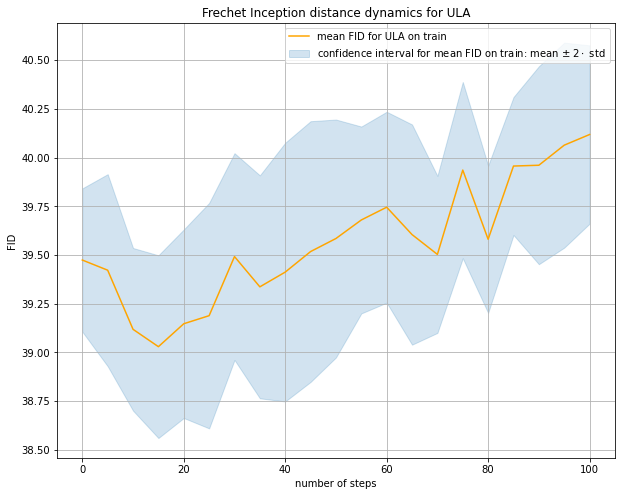

In [19]:
method_name = 'ULA'
every_step = 5
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)

# MALA

In [4]:
import torch
use_gpu = True if torch.cuda.is_available() else False

# trained on high-quality celebrity faces "celebA" dataset
# this model outputs 512 x 512 pixel images
model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub',
                       'PGAN', model_name='celeba',
                       pretrained=True, useGPU=use_gpu)

device = torch.device('cuda:1')
D = model.getOriginalD().eval().requires_grad_(False).to(device)
G = model.getOriginalG().eval().requires_grad_(False).to(device)

Using cache found in /home/daniil/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !


In [5]:
noise, _ = model.buildNoiseData(1)
z_dim = noise.shape[1]

loc = torch.zeros(z_dim).to(device)
scale = torch.ones(z_dim).to(device)

proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc
proposal_args.scale = scale
proposal = IndependentNormal(proposal_args)

log_prob = True
normalize_to_0_1 = True

target_gan = partial(gan_energy,
                     generator = G, 
                     discriminator = D, 
                     proposal = proposal,
                     normalize_to_0_1 = normalize_to_0_1,
                     log_prob = log_prob)

In [6]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

batch_size = 40
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5
continue_z = None

z_last_np, zs = mala_sampling(target_gan, proposal, batch_size, n,
                                  path_to_save, file_name, every_step,
                                  continue_z,
                                  n_steps, grad_step, eps_scale)

  0%|          | 1/250 [02:28<10:14:46, 148.14s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_0.npy was saved, file shape = (21, 40, 512)


  1%|          | 2/250 [05:00<10:17:02, 149.28s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_40.npy was saved, file shape = (21, 40, 512)


  1%|          | 3/250 [07:31<10:17:39, 150.04s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_80.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 4/250 [10:03<10:17:18, 150.56s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_120.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 5/250 [12:35<10:16:18, 150.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_160.npy was saved, file shape = (21, 40, 512)


  2%|▏         | 6/250 [15:07<10:14:50, 151.19s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_200.npy was saved, file shape = (21, 40, 512)


  3%|▎         | 7/250 [17:39<10:13:00, 151.36s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_240.npy was saved, file shape = (21, 40, 512)


  3%|▎         | 8/250 [20:10<10:10:57, 151.48s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_280.npy was saved, file shape = (21, 40, 512)


  4%|▎         | 9/250 [22:42<10:08:43, 151.55s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_320.npy was saved, file shape = (21, 40, 512)


  4%|▍         | 10/250 [25:14<10:06:23, 151.60s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_360.npy was saved, file shape = (21, 40, 512)


  4%|▍         | 11/250 [27:45<10:04:01, 151.64s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_400.npy was saved, file shape = (21, 40, 512)


  5%|▍         | 12/250 [30:17<10:01:39, 151.68s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_440.npy was saved, file shape = (21, 40, 512)


  5%|▌         | 13/250 [32:49<9:59:15, 151.71s/it] 

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_480.npy was saved, file shape = (21, 40, 512)


  6%|▌         | 14/250 [35:21<9:56:48, 151.73s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_520.npy was saved, file shape = (21, 40, 512)


  6%|▌         | 15/250 [37:53<9:54:20, 151.75s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_560.npy was saved, file shape = (21, 40, 512)


  6%|▋         | 16/250 [40:24<9:51:51, 151.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_600.npy was saved, file shape = (21, 40, 512)


  7%|▋         | 17/250 [42:56<9:49:20, 151.76s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_640.npy was saved, file shape = (21, 40, 512)


  7%|▋         | 18/250 [45:28<9:46:52, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_680.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 19/250 [48:00<9:44:24, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_720.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 20/250 [50:32<9:41:52, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_760.npy was saved, file shape = (21, 40, 512)


  8%|▊         | 21/250 [53:03<9:39:20, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_800.npy was saved, file shape = (21, 40, 512)


  9%|▉         | 22/250 [55:35<9:36:49, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_840.npy was saved, file shape = (21, 40, 512)


  9%|▉         | 23/250 [58:07<9:34:18, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_880.npy was saved, file shape = (21, 40, 512)


 10%|▉         | 24/250 [1:00:39<9:31:47, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_920.npy was saved, file shape = (21, 40, 512)


 10%|█         | 25/250 [1:03:11<9:29:16, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_960.npy was saved, file shape = (21, 40, 512)


 10%|█         | 26/250 [1:05:42<9:26:44, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1000.npy was saved, file shape = (21, 40, 512)


 11%|█         | 27/250 [1:08:14<9:24:14, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1040.npy was saved, file shape = (21, 40, 512)


 11%|█         | 28/250 [1:10:46<9:21:43, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1080.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 29/250 [1:13:18<9:19:11, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1120.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 30/250 [1:15:50<9:16:40, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1160.npy was saved, file shape = (21, 40, 512)


 12%|█▏        | 31/250 [1:18:21<9:14:07, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1200.npy was saved, file shape = (21, 40, 512)


 13%|█▎        | 32/250 [1:20:53<9:11:37, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1240.npy was saved, file shape = (21, 40, 512)


 13%|█▎        | 33/250 [1:23:25<9:09:01, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1280.npy was saved, file shape = (21, 40, 512)


 14%|█▎        | 34/250 [1:25:57<9:06:26, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1320.npy was saved, file shape = (21, 40, 512)


 14%|█▍        | 35/250 [1:28:29<9:03:54, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1360.npy was saved, file shape = (21, 40, 512)


 14%|█▍        | 36/250 [1:31:00<9:01:22, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1400.npy was saved, file shape = (21, 40, 512)


 15%|█▍        | 37/250 [1:33:32<8:58:51, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1440.npy was saved, file shape = (21, 40, 512)


 15%|█▌        | 38/250 [1:36:04<8:56:23, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1480.npy was saved, file shape = (21, 40, 512)


 16%|█▌        | 39/250 [1:38:36<8:53:56, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1520.npy was saved, file shape = (21, 40, 512)


 16%|█▌        | 40/250 [1:41:08<8:51:29, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1560.npy was saved, file shape = (21, 40, 512)


 16%|█▋        | 41/250 [1:43:40<8:48:58, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1600.npy was saved, file shape = (21, 40, 512)


 17%|█▋        | 42/250 [1:46:12<8:46:27, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1640.npy was saved, file shape = (21, 40, 512)


 17%|█▋        | 43/250 [1:48:43<8:43:56, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1680.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 44/250 [1:51:15<8:41:25, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1720.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 45/250 [1:53:47<8:38:53, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1760.npy was saved, file shape = (21, 40, 512)


 18%|█▊        | 46/250 [1:56:19<8:36:23, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1800.npy was saved, file shape = (21, 40, 512)


 19%|█▉        | 47/250 [1:58:51<8:33:53, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1840.npy was saved, file shape = (21, 40, 512)


 19%|█▉        | 48/250 [2:01:23<8:31:16, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1880.npy was saved, file shape = (21, 40, 512)


 20%|█▉        | 49/250 [2:03:55<8:28:41, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1920.npy was saved, file shape = (21, 40, 512)


 20%|██        | 50/250 [2:06:27<8:26:10, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_1960.npy was saved, file shape = (21, 40, 512)


 20%|██        | 51/250 [2:08:58<8:23:37, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2000.npy was saved, file shape = (21, 40, 512)


 21%|██        | 52/250 [2:11:30<8:21:04, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2040.npy was saved, file shape = (21, 40, 512)


 21%|██        | 53/250 [2:14:02<8:18:30, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2080.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 54/250 [2:16:34<8:15:59, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2120.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 55/250 [2:19:06<8:13:24, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2160.npy was saved, file shape = (21, 40, 512)


 22%|██▏       | 56/250 [2:21:37<8:10:52, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2200.npy was saved, file shape = (21, 40, 512)


 23%|██▎       | 57/250 [2:24:09<8:08:20, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2240.npy was saved, file shape = (21, 40, 512)


 23%|██▎       | 58/250 [2:26:41<8:05:47, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2280.npy was saved, file shape = (21, 40, 512)


 24%|██▎       | 59/250 [2:29:13<8:03:14, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2320.npy was saved, file shape = (21, 40, 512)


 24%|██▍       | 60/250 [2:31:45<8:00:43, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2360.npy was saved, file shape = (21, 40, 512)


 24%|██▍       | 61/250 [2:34:16<7:58:11, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2400.npy was saved, file shape = (21, 40, 512)


 25%|██▍       | 62/250 [2:36:48<7:55:39, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2440.npy was saved, file shape = (21, 40, 512)


 25%|██▌       | 63/250 [2:39:20<7:53:06, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2480.npy was saved, file shape = (21, 40, 512)


 26%|██▌       | 64/250 [2:41:52<7:50:35, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2520.npy was saved, file shape = (21, 40, 512)


 26%|██▌       | 65/250 [2:44:24<7:48:05, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2560.npy was saved, file shape = (21, 40, 512)


 26%|██▋       | 66/250 [2:46:55<7:45:33, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2600.npy was saved, file shape = (21, 40, 512)


 27%|██▋       | 67/250 [2:49:27<7:43:00, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2640.npy was saved, file shape = (21, 40, 512)


 27%|██▋       | 68/250 [2:51:59<7:40:31, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2680.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 69/250 [2:54:31<7:38:00, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2720.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 70/250 [2:57:03<7:35:29, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2760.npy was saved, file shape = (21, 40, 512)


 28%|██▊       | 71/250 [2:59:35<7:33:00, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2800.npy was saved, file shape = (21, 40, 512)


 29%|██▉       | 72/250 [3:02:07<7:30:32, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2840.npy was saved, file shape = (21, 40, 512)


 29%|██▉       | 73/250 [3:04:39<7:28:03, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2880.npy was saved, file shape = (21, 40, 512)


 30%|██▉       | 74/250 [3:07:10<7:25:27, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2920.npy was saved, file shape = (21, 40, 512)


 30%|███       | 75/250 [3:09:42<7:22:56, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_2960.npy was saved, file shape = (21, 40, 512)


 30%|███       | 76/250 [3:12:14<7:20:24, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3000.npy was saved, file shape = (21, 40, 512)


 31%|███       | 77/250 [3:14:46<7:17:53, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3040.npy was saved, file shape = (21, 40, 512)


 31%|███       | 78/250 [3:17:18<7:15:23, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3080.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 79/250 [3:19:50<7:12:53, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3120.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 80/250 [3:22:22<7:10:21, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3160.npy was saved, file shape = (21, 40, 512)


 32%|███▏      | 81/250 [3:24:54<7:07:51, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3200.npy was saved, file shape = (21, 40, 512)


 33%|███▎      | 82/250 [3:27:26<7:05:19, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3240.npy was saved, file shape = (21, 40, 512)


 33%|███▎      | 83/250 [3:29:57<7:02:50, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3280.npy was saved, file shape = (21, 40, 512)


 34%|███▎      | 84/250 [3:32:29<7:00:21, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3320.npy was saved, file shape = (21, 40, 512)


 34%|███▍      | 85/250 [3:35:01<6:57:50, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3360.npy was saved, file shape = (21, 40, 512)


 34%|███▍      | 86/250 [3:37:33<6:55:14, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3400.npy was saved, file shape = (21, 40, 512)


 35%|███▍      | 87/250 [3:40:05<6:52:38, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3440.npy was saved, file shape = (21, 40, 512)


 35%|███▌      | 88/250 [3:42:37<6:50:06, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3480.npy was saved, file shape = (21, 40, 512)


 36%|███▌      | 89/250 [3:45:09<6:47:35, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3520.npy was saved, file shape = (21, 40, 512)


 36%|███▌      | 90/250 [3:47:41<6:45:01, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3560.npy was saved, file shape = (21, 40, 512)


 36%|███▋      | 91/250 [3:50:13<6:42:28, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3600.npy was saved, file shape = (21, 40, 512)


 37%|███▋      | 92/250 [3:52:44<6:39:55, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3640.npy was saved, file shape = (21, 40, 512)


 37%|███▋      | 93/250 [3:55:16<6:37:22, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3680.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 94/250 [3:57:48<6:34:49, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3720.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 95/250 [4:00:20<6:32:17, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3760.npy was saved, file shape = (21, 40, 512)


 38%|███▊      | 96/250 [4:02:52<6:29:46, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3800.npy was saved, file shape = (21, 40, 512)


 39%|███▉      | 97/250 [4:05:24<6:27:15, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3840.npy was saved, file shape = (21, 40, 512)


 39%|███▉      | 98/250 [4:07:56<6:24:44, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3880.npy was saved, file shape = (21, 40, 512)


 40%|███▉      | 99/250 [4:10:28<6:22:12, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3920.npy was saved, file shape = (21, 40, 512)


 40%|████      | 100/250 [4:12:59<6:19:40, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_3960.npy was saved, file shape = (21, 40, 512)


 40%|████      | 101/250 [4:15:31<6:17:09, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4000.npy was saved, file shape = (21, 40, 512)


 41%|████      | 102/250 [4:18:03<6:14:39, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4040.npy was saved, file shape = (21, 40, 512)


 41%|████      | 103/250 [4:20:35<6:12:08, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4080.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 104/250 [4:23:07<6:09:38, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4120.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 105/250 [4:25:39<6:07:08, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4160.npy was saved, file shape = (21, 40, 512)


 42%|████▏     | 106/250 [4:28:11<6:04:38, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4200.npy was saved, file shape = (21, 40, 512)


 43%|████▎     | 107/250 [4:30:43<6:02:07, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4240.npy was saved, file shape = (21, 40, 512)


 43%|████▎     | 108/250 [4:33:15<5:59:35, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4280.npy was saved, file shape = (21, 40, 512)


 44%|████▎     | 109/250 [4:35:47<5:57:06, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4320.npy was saved, file shape = (21, 40, 512)


 44%|████▍     | 110/250 [4:38:19<5:54:35, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4360.npy was saved, file shape = (21, 40, 512)


 44%|████▍     | 111/250 [4:40:51<5:52:03, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4400.npy was saved, file shape = (21, 40, 512)


 45%|████▍     | 112/250 [4:43:23<5:49:34, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4440.npy was saved, file shape = (21, 40, 512)


 45%|████▌     | 113/250 [4:45:55<5:47:03, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4480.npy was saved, file shape = (21, 40, 512)


 46%|████▌     | 114/250 [4:48:27<5:44:31, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4520.npy was saved, file shape = (21, 40, 512)


 46%|████▌     | 115/250 [4:50:59<5:42:01, 152.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4560.npy was saved, file shape = (21, 40, 512)


 46%|████▋     | 116/250 [4:53:31<5:39:29, 152.01s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4600.npy was saved, file shape = (21, 40, 512)


 47%|████▋     | 117/250 [4:56:03<5:36:56, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4640.npy was saved, file shape = (21, 40, 512)


 47%|████▋     | 118/250 [4:58:35<5:34:23, 151.99s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4680.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 119/250 [5:01:07<5:31:51, 152.00s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4720.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 120/250 [5:03:39<5:29:17, 151.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4760.npy was saved, file shape = (21, 40, 512)


 48%|████▊     | 121/250 [5:06:11<5:26:44, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4800.npy was saved, file shape = (21, 40, 512)


 49%|████▉     | 122/250 [5:08:43<5:24:13, 151.98s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4840.npy was saved, file shape = (21, 40, 512)


 49%|████▉     | 123/250 [5:11:15<5:21:39, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4880.npy was saved, file shape = (21, 40, 512)


 50%|████▉     | 124/250 [5:13:47<5:19:07, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4920.npy was saved, file shape = (21, 40, 512)


 50%|█████     | 125/250 [5:16:19<5:16:36, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_4960.npy was saved, file shape = (21, 40, 512)


 50%|█████     | 126/250 [5:18:51<5:14:03, 151.97s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5000.npy was saved, file shape = (21, 40, 512)


 51%|█████     | 127/250 [5:21:23<5:11:31, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5040.npy was saved, file shape = (21, 40, 512)


 51%|█████     | 128/250 [5:23:54<5:08:56, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5080.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 129/250 [5:26:26<5:06:23, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5120.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 130/250 [5:28:58<5:03:51, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5160.npy was saved, file shape = (21, 40, 512)


 52%|█████▏    | 131/250 [5:31:30<5:01:18, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5200.npy was saved, file shape = (21, 40, 512)


 53%|█████▎    | 132/250 [5:34:02<4:58:45, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5240.npy was saved, file shape = (21, 40, 512)


 53%|█████▎    | 133/250 [5:36:34<4:56:13, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5280.npy was saved, file shape = (21, 40, 512)


 54%|█████▎    | 134/250 [5:39:06<4:53:44, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5320.npy was saved, file shape = (21, 40, 512)


 54%|█████▍    | 135/250 [5:41:38<4:51:11, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5360.npy was saved, file shape = (21, 40, 512)


 54%|█████▍    | 136/250 [5:44:10<4:48:38, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5400.npy was saved, file shape = (21, 40, 512)


 55%|█████▍    | 137/250 [5:46:42<4:46:07, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5440.npy was saved, file shape = (21, 40, 512)


 55%|█████▌    | 138/250 [5:49:14<4:43:35, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5480.npy was saved, file shape = (21, 40, 512)


 56%|█████▌    | 139/250 [5:51:46<4:41:03, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5520.npy was saved, file shape = (21, 40, 512)


 56%|█████▌    | 140/250 [5:54:17<4:38:32, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5560.npy was saved, file shape = (21, 40, 512)


 56%|█████▋    | 141/250 [5:56:49<4:35:59, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5600.npy was saved, file shape = (21, 40, 512)


 57%|█████▋    | 142/250 [5:59:21<4:33:25, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5640.npy was saved, file shape = (21, 40, 512)


 57%|█████▋    | 143/250 [6:01:53<4:30:54, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5680.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 144/250 [6:04:25<4:28:24, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5720.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 145/250 [6:06:57<4:25:54, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5760.npy was saved, file shape = (21, 40, 512)


 58%|█████▊    | 146/250 [6:09:29<4:23:23, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5800.npy was saved, file shape = (21, 40, 512)


 59%|█████▉    | 147/250 [6:12:01<4:20:49, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5840.npy was saved, file shape = (21, 40, 512)


 59%|█████▉    | 148/250 [6:14:33<4:18:19, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5880.npy was saved, file shape = (21, 40, 512)


 60%|█████▉    | 149/250 [6:17:05<4:15:47, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5920.npy was saved, file shape = (21, 40, 512)


 60%|██████    | 150/250 [6:19:37<4:13:15, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_5960.npy was saved, file shape = (21, 40, 512)


 60%|██████    | 151/250 [6:22:09<4:10:42, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6000.npy was saved, file shape = (21, 40, 512)


 61%|██████    | 152/250 [6:24:41<4:08:07, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6040.npy was saved, file shape = (21, 40, 512)


 61%|██████    | 153/250 [6:27:13<4:05:36, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6080.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 154/250 [6:29:45<4:03:05, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6120.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 155/250 [6:32:16<4:00:32, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6160.npy was saved, file shape = (21, 40, 512)


 62%|██████▏   | 156/250 [6:34:48<3:57:59, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6200.npy was saved, file shape = (21, 40, 512)


 63%|██████▎   | 157/250 [6:37:20<3:55:27, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6240.npy was saved, file shape = (21, 40, 512)


 63%|██████▎   | 158/250 [6:39:52<3:52:55, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6280.npy was saved, file shape = (21, 40, 512)


 64%|██████▎   | 159/250 [6:42:24<3:50:26, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6320.npy was saved, file shape = (21, 40, 512)


 64%|██████▍   | 160/250 [6:44:56<3:47:56, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6360.npy was saved, file shape = (21, 40, 512)


 64%|██████▍   | 161/250 [6:47:28<3:45:24, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6400.npy was saved, file shape = (21, 40, 512)


 65%|██████▍   | 162/250 [6:50:00<3:42:52, 151.96s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6440.npy was saved, file shape = (21, 40, 512)


 65%|██████▌   | 163/250 [6:52:32<3:40:19, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6480.npy was saved, file shape = (21, 40, 512)


 66%|██████▌   | 164/250 [6:55:04<3:37:46, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6520.npy was saved, file shape = (21, 40, 512)


 66%|██████▌   | 165/250 [6:57:36<3:35:13, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6560.npy was saved, file shape = (21, 40, 512)


 66%|██████▋   | 166/250 [7:00:08<3:32:40, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6600.npy was saved, file shape = (21, 40, 512)


 67%|██████▋   | 167/250 [7:02:40<3:30:10, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6640.npy was saved, file shape = (21, 40, 512)


 67%|██████▋   | 168/250 [7:05:12<3:27:39, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6680.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 169/250 [7:07:44<3:25:06, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6720.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 170/250 [7:10:16<3:22:35, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6760.npy was saved, file shape = (21, 40, 512)


 68%|██████▊   | 171/250 [7:12:47<3:20:01, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6800.npy was saved, file shape = (21, 40, 512)


 69%|██████▉   | 172/250 [7:15:19<3:17:29, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6840.npy was saved, file shape = (21, 40, 512)


 69%|██████▉   | 173/250 [7:17:51<3:14:57, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6880.npy was saved, file shape = (21, 40, 512)


 70%|██████▉   | 174/250 [7:20:23<3:12:25, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6920.npy was saved, file shape = (21, 40, 512)


 70%|███████   | 175/250 [7:22:55<3:09:53, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_6960.npy was saved, file shape = (21, 40, 512)


 70%|███████   | 176/250 [7:25:27<3:07:21, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7000.npy was saved, file shape = (21, 40, 512)


 71%|███████   | 177/250 [7:27:59<3:04:49, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7040.npy was saved, file shape = (21, 40, 512)


 71%|███████   | 178/250 [7:30:31<3:02:18, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7080.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 179/250 [7:33:03<2:59:47, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7120.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 180/250 [7:35:35<2:57:15, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7160.npy was saved, file shape = (21, 40, 512)


 72%|███████▏  | 181/250 [7:38:07<2:54:42, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7200.npy was saved, file shape = (21, 40, 512)


 73%|███████▎  | 182/250 [7:40:38<2:52:09, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7240.npy was saved, file shape = (21, 40, 512)


 73%|███████▎  | 183/250 [7:43:10<2:49:37, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7280.npy was saved, file shape = (21, 40, 512)


 74%|███████▎  | 184/250 [7:45:42<2:47:05, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7320.npy was saved, file shape = (21, 40, 512)


 74%|███████▍  | 185/250 [7:48:14<2:44:34, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7360.npy was saved, file shape = (21, 40, 512)


 74%|███████▍  | 186/250 [7:50:46<2:42:01, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7400.npy was saved, file shape = (21, 40, 512)


 75%|███████▍  | 187/250 [7:53:18<2:39:29, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7440.npy was saved, file shape = (21, 40, 512)


 75%|███████▌  | 188/250 [7:55:50<2:36:57, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7480.npy was saved, file shape = (21, 40, 512)


 76%|███████▌  | 189/250 [7:58:22<2:34:26, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7520.npy was saved, file shape = (21, 40, 512)


 76%|███████▌  | 190/250 [8:00:54<2:31:55, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7560.npy was saved, file shape = (21, 40, 512)


 76%|███████▋  | 191/250 [8:03:26<2:29:24, 151.94s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7600.npy was saved, file shape = (21, 40, 512)


 77%|███████▋  | 192/250 [8:05:58<2:26:52, 151.95s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7640.npy was saved, file shape = (21, 40, 512)


 77%|███████▋  | 193/250 [8:08:30<2:24:20, 151.93s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7680.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 194/250 [8:11:01<2:21:47, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7720.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 195/250 [8:13:33<2:19:13, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7760.npy was saved, file shape = (21, 40, 512)


 78%|███████▊  | 196/250 [8:16:05<2:16:40, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7800.npy was saved, file shape = (21, 40, 512)


 79%|███████▉  | 197/250 [8:18:37<2:14:08, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7840.npy was saved, file shape = (21, 40, 512)


 79%|███████▉  | 198/250 [8:21:09<2:11:35, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7880.npy was saved, file shape = (21, 40, 512)


 80%|███████▉  | 199/250 [8:23:41<2:09:03, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7920.npy was saved, file shape = (21, 40, 512)


 80%|████████  | 200/250 [8:26:12<2:06:32, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_7960.npy was saved, file shape = (21, 40, 512)


 80%|████████  | 201/250 [8:28:44<2:04:00, 151.84s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8000.npy was saved, file shape = (21, 40, 512)


 81%|████████  | 202/250 [8:31:16<2:01:28, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8040.npy was saved, file shape = (21, 40, 512)


 81%|████████  | 203/250 [8:33:48<1:58:57, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8080.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 204/250 [8:36:20<1:56:25, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8120.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 205/250 [8:38:52<1:53:53, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8160.npy was saved, file shape = (21, 40, 512)


 82%|████████▏ | 206/250 [8:41:24<1:51:21, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8200.npy was saved, file shape = (21, 40, 512)


 83%|████████▎ | 207/250 [8:43:56<1:48:50, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8240.npy was saved, file shape = (21, 40, 512)


 83%|████████▎ | 208/250 [8:46:27<1:46:18, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8280.npy was saved, file shape = (21, 40, 512)


 84%|████████▎ | 209/250 [8:48:59<1:43:46, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8320.npy was saved, file shape = (21, 40, 512)


 84%|████████▍ | 210/250 [8:51:31<1:41:15, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8360.npy was saved, file shape = (21, 40, 512)


 84%|████████▍ | 211/250 [8:54:03<1:38:43, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8400.npy was saved, file shape = (21, 40, 512)


 85%|████████▍ | 212/250 [8:56:35<1:36:11, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8440.npy was saved, file shape = (21, 40, 512)


 85%|████████▌ | 213/250 [8:59:07<1:33:39, 151.89s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8480.npy was saved, file shape = (21, 40, 512)


 86%|████████▌ | 214/250 [9:01:39<1:31:07, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8520.npy was saved, file shape = (21, 40, 512)


 86%|████████▌ | 215/250 [9:04:11<1:28:35, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8560.npy was saved, file shape = (21, 40, 512)


 86%|████████▋ | 216/250 [9:06:43<1:26:04, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8600.npy was saved, file shape = (21, 40, 512)


 87%|████████▋ | 217/250 [9:09:15<1:23:33, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8640.npy was saved, file shape = (21, 40, 512)


 87%|████████▋ | 218/250 [9:11:46<1:21:01, 151.92s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8680.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 219/250 [9:14:18<1:18:29, 151.91s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8720.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 220/250 [9:16:50<1:15:56, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8760.npy was saved, file shape = (21, 40, 512)


 88%|████████▊ | 221/250 [9:19:22<1:13:25, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8800.npy was saved, file shape = (21, 40, 512)


 89%|████████▉ | 222/250 [9:21:54<1:10:53, 151.90s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8840.npy was saved, file shape = (21, 40, 512)


 89%|████████▉ | 223/250 [9:24:26<1:08:20, 151.88s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8880.npy was saved, file shape = (21, 40, 512)


 90%|████████▉ | 224/250 [9:26:58<1:05:48, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8920.npy was saved, file shape = (21, 40, 512)


 90%|█████████ | 225/250 [9:29:30<1:03:16, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_8960.npy was saved, file shape = (21, 40, 512)


 90%|█████████ | 226/250 [9:32:01<1:00:44, 151.87s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9000.npy was saved, file shape = (21, 40, 512)


 91%|█████████ | 227/250 [9:34:33<58:12, 151.87s/it]  

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9040.npy was saved, file shape = (21, 40, 512)


 91%|█████████ | 228/250 [9:37:05<55:40, 151.85s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9080.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 229/250 [9:39:37<53:08, 151.83s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9120.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 230/250 [9:42:09<50:36, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9160.npy was saved, file shape = (21, 40, 512)


 92%|█████████▏| 231/250 [9:44:40<48:04, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9200.npy was saved, file shape = (21, 40, 512)


 93%|█████████▎| 232/250 [9:47:12<45:32, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9240.npy was saved, file shape = (21, 40, 512)


 93%|█████████▎| 233/250 [9:49:44<43:00, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9280.npy was saved, file shape = (21, 40, 512)


 94%|█████████▎| 234/250 [9:52:16<40:28, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9320.npy was saved, file shape = (21, 40, 512)


 94%|█████████▍| 235/250 [9:54:47<37:56, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9360.npy was saved, file shape = (21, 40, 512)


 94%|█████████▍| 236/250 [9:57:19<35:24, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9400.npy was saved, file shape = (21, 40, 512)


 95%|█████████▍| 237/250 [9:59:51<32:53, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9440.npy was saved, file shape = (21, 40, 512)


 95%|█████████▌| 238/250 [10:02:23<30:21, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9480.npy was saved, file shape = (21, 40, 512)


 96%|█████████▌| 239/250 [10:04:55<27:49, 151.78s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9520.npy was saved, file shape = (21, 40, 512)


 96%|█████████▌| 240/250 [10:07:26<25:17, 151.77s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9560.npy was saved, file shape = (21, 40, 512)


 96%|█████████▋| 241/250 [10:09:58<22:46, 151.79s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9600.npy was saved, file shape = (21, 40, 512)


 97%|█████████▋| 242/250 [10:12:30<20:14, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9640.npy was saved, file shape = (21, 40, 512)


 97%|█████████▋| 243/250 [10:15:02<17:42, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9680.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 244/250 [10:17:34<15:10, 151.82s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9720.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 245/250 [10:20:05<12:39, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9760.npy was saved, file shape = (21, 40, 512)


 98%|█████████▊| 246/250 [10:22:37<10:07, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9800.npy was saved, file shape = (21, 40, 512)


 99%|█████████▉| 247/250 [10:25:09<07:35, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9840.npy was saved, file shape = (21, 40, 512)


 99%|█████████▉| 248/250 [10:27:41<05:03, 151.80s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9880.npy was saved, file shape = (21, 40, 512)


100%|█████████▉| 249/250 [10:30:13<02:31, 151.81s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9920.npy was saved, file shape = (21, 40, 512)


100%|██████████| 250/250 [10:32:44<00:00, 151.86s/it]

file /home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_eps_0.01_noise_scale_0.1_nsteps_100_batch_num_9960.npy was saved, file shape = (21, 40, 512)


In [8]:
batch_size = 40
n = 10000
n_steps = 100
grad_step = 0.01
eps_scale = 0.1
method_name = 'mala_pgan'
path_to_save = '/home/daniil/gans-mcmc/saved_numpy_arrays'
file_name = f'{method_name}_eps_{grad_step}_noise_scale_{eps_scale}_nsteps_{n_steps}'
every_step = 5

load_np = []

for i in tqdm(range(0, n, batch_size)):
    cur_file_name = file_name + f"_batch_num_{i}.npy"
    cur_path_to_save = os.path.join(path_to_save, cur_file_name)
    cur_zs = np.load(cur_path_to_save)
    load_np.append(cur_zs)
    
load_np = np.array(load_np)

100%|██████████| 250/250 [00:00<00:00, 2423.93it/s]


In [9]:
load_np = np.concatenate(load_np.transpose(0, 2, 1, 3), axis = 0).transpose(1, 0, 2)

In [11]:
method_name = 'mala_pgan_10k'
random_seed = 42
every_step = 5
batch_size = 40
calculate_is = False
dataroot = '/home/daniil/gans-mcmc/celeba/celeba_images'
image_size = 64
path_to_save_np = '/home/daniil/gans-mcmc/saved_numpy_arrays'
ula_scores = calculate_celeba_statistics(load_np, 
                                         G,
                                         device, 
                                         batch_size,
                                         path_to_save_np,
                                         method_name,
                                         image_size,
                                         dataroot,
                                         calculate_is=calculate_is,
                                         random_seed=random_seed,
                                         every_step=every_step)

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/connection.p

------------------------------------
step = 0
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...


249it [00:45,  5.42it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.54it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_0.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.73s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.49224227043685, score 0.3633112578851565
time for FID calculation on train = 138.322s
------------------------------------
step = 5
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.39it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.73it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_5.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.53985919452416, score 0.37168714741425724
time for FID calculation on train = 137.355s
------------------------------------
step = 10
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.72it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_10.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.70s/it, mean=39.4]

FID score for train Celeba with mala_pgan_10k: mean 39.410964370338164, score 0.37659564481277863
time for FID calculation on train = 118.579s
------------------------------------
step = 15
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



0it [00:00, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb3f4192e50>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/multiprocessing/process.py", line 147, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb3f4192e50>
Traceback (most recent call last):
  File "/home/daniil/anaconda3/envs/myenv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/ho

shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.65it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_15.npy


FID: 100%|██████████| 10/10 [00:38<00:00,  3.89s/it, mean=39.4]

FID score for train Celeba with mala_pgan_10k: mean 39.444790594908696, score 0.3509050578008698
time for FID calculation on train = 140.802s
------------------------------------
step = 20
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.68it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_20.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it, mean=39.5]

FID score for train Celeba with mala_pgan_10k: mean 39.47249059788347, score 0.38404543805628805
time for FID calculation on train = 138.822s
------------------------------------
step = 25
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.44it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_25.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.60s/it, mean=39.6]

FID score for train Celeba with mala_pgan_10k: mean 39.614653353335186, score 0.376738603704695
time for FID calculation on train = 117.917s
------------------------------------
step = 30
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_30.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.65s/it, mean=39.6]

FID score for train Celeba with mala_pgan_10k: mean 39.64651066284713, score 0.3541026569179604
time for FID calculation on train = 158.521s
------------------------------------
step = 35
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_35.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it, mean=39.7]

FID score for train Celeba with mala_pgan_10k: mean 39.69578188658501, score 0.36700282839524595
time for FID calculation on train = 138.839s
------------------------------------
step = 40
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.35it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_40.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=39.8]

FID score for train Celeba with mala_pgan_10k: mean 39.81962426564809, score 0.3480711717996681
time for FID calculation on train = 118.519s
------------------------------------
step = 45
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.33it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_45.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 39.98769636295865, score 0.35103800093569665
time for FID calculation on train = 158.288s
------------------------------------
step = 50
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.67it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_50.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it, mean=39.9]

FID score for train Celeba with mala_pgan_10k: mean 39.87204517323808, score 0.3364095094858025
time for FID calculation on train = 139.712s
------------------------------------
step = 55
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.65it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_55.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.66s/it, mean=39.9]

FID score for train Celeba with mala_pgan_10k: mean 39.9428545305906, score 0.33327949217431463
time for FID calculation on train = 118.509s
------------------------------------
step = 60
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.33it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.49it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_60.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 39.97641879727401, score 0.32074917753658816
time for FID calculation on train = 158.765s
------------------------------------
step = 65
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.62it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_65.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.74s/it, mean=40] 

FID score for train Celeba with mala_pgan_10k: mean 40.02580341332224, score 0.32590058425449764
time for FID calculation on train = 139.049s
------------------------------------
step = 70
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_70.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.68s/it, mean=40.1]

FID score for train Celeba with mala_pgan_10k: mean 40.06980723676943, score 0.3371758612599065
time for FID calculation on train = 118.734s
------------------------------------
step = 75
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.61it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_75.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it, mean=40.2]

FID score for train Celeba with mala_pgan_10k: mean 40.176525751607016, score 0.3157448656391305
time for FID calculation on train = 159.812s
------------------------------------
step = 80
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.69it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_80.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.2922301381851, score 0.29026214926849503
time for FID calculation on train = 138.688s
------------------------------------
step = 85
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.36it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.66it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_85.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.63s/it, mean=40.4]

FID score for train Celeba with mala_pgan_10k: mean 40.42692915024695, score 0.3382269176924389
time for FID calculation on train = 138.146s
------------------------------------
step = 90
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.35it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.58it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_90.npy


FID: 100%|██████████| 10/10 [00:37<00:00,  3.71s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.28923106458471, score 0.3859478369932057
time for FID calculation on train = 118.96s
------------------------------------
step = 95
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.34it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:16, 14.63it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_95.npy


FID: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, mean=40.4]

FID score for train Celeba with mala_pgan_10k: mean 40.356096643630984, score 0.3508182927865174
time for FID calculation on train = 157.53s
------------------------------------
step = 100
sample size = (10000, 512)
sample size after deleteting nans = (10000, 512)
start to calculate FID score for train Celeba over 10000 images...



249it [00:46,  5.37it/s]


shape of generated images = (10000, 3, 64, 64)
shape of real images = (10000, 3, 64, 64)


  1%|          | 2/250 [00:00<00:17, 14.45it/s]

/home/daniil/gans-mcmc/saved_numpy_arrays/mala_pgan_10k_pretrained_fake_train_step_100.npy


FID: 100%|██████████| 10/10 [00:36<00:00,  3.64s/it, mean=40.3]

FID score for train Celeba with mala_pgan_10k: mean 40.28399743950026, score 0.36079643190963034
time for FID calculation on train = 138.234s


In [12]:
method_name = 'mala_pgan_10k'
path_to_np_files = '/home/daniil/gans-mcmc/saved_numpy_arrays'
name_fid_mean_train = f'{method_name}_fid_scores_mean_train.npy'
path_to_save_fid_mean_train = os.path.join(path_to_np_files, name_fid_mean_train)
name_fid_std_train = f'{method_name}_fid_scores_std_train.npy'
path_to_save_fid_std_train = os.path.join(path_to_np_files, name_fid_std_train)

fid_scores_mean_train = np.load(path_to_save_fid_mean_train)
fid_scores_std_train = np.load(path_to_save_fid_std_train)

scores = {'fid_scores_mean_train': fid_scores_mean_train,
    'fid_scores_std_train': fid_scores_std_train
}

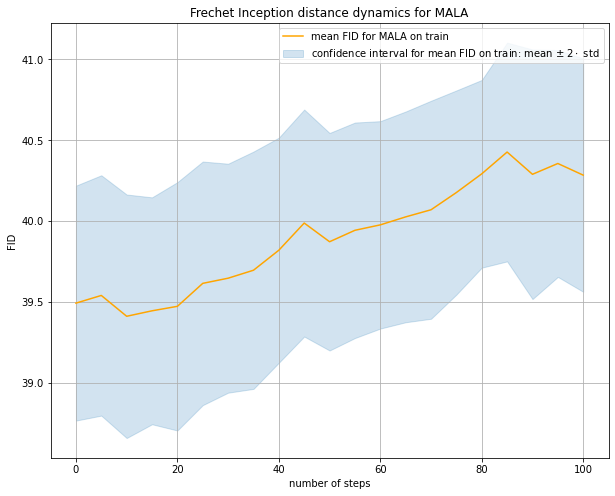

In [13]:
method_name = 'MALA'
every_step = 5
figsize = (10, 8)
grad_step = 0.01
eps_scale = 0.1
path_to_save = "/home/daniil/gans-mcmc/gans_sampling/figs"
plot_scores_cifar10_dynamics(scores,
                             every_step, 
                             method_name,
                             figsize,
                             path_to_save,
                             grad_step,
                             eps_scale,
                             coef = 2.0,
                             plot_is = False,
                             plot_fid_train = True,
                             plot_fid_test = False)